In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.8 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import matplotlib.pyplot as plt

In [ ]:
test_sample_image='/content/drive/MyDrive/colab_data/Test/Cardiomegaly/00000032_021.png'

In [ ]:
from PIL import Image
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



# Load the image file
image_path = test_sample_image
image = Image.open(image_path)

def add_gaussian_noise(image, mean=0, std=0.1):
    image = transforms.ToTensor()(image)  # Convert the image to a tensor
    noise = torch.randn_like(image) * std + mean
    noisy_image = image + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)  # Ensure the image values are in the valid range [0, 1]
    return transforms.ToPILImage()(noisy_image)  # Convert the tensor back to an image

# Create a custom transformation using transforms.Lambda
add_gaussian_noise_transform = transforms.Lambda(lambda x: add_gaussian_noise(x, mean=0, std=0.1))

# Define data augmentation transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomApply([transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=0.5),
    transforms.RandomRotation(25),  # Randomly rotate the image up to 20 degrees
    transforms.RandomVerticalFlip(),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2))], p=0.5),  # Apply random affine transformations
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.2, p=0.5)], p=0.5),  # Apply random perspective transformation
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([add_gaussian_noise_transform],p=0.5),
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor


])



# Apply the transformation to the image
tensor_image = transform(image)

# Reshape the tensor to match the expected shape
tensor_image = tensor_image.unsqueeze(0)  # Add batch dimension

# Print the shape and data type of the tensor
print("Tensor shape:", tensor_image.shape)
print("Tensor data type:", tensor_image.dtype)

# # Permute dimensions to match the expected shape (B, H, W, C)
tensor_image = tensor_image.permute(0, 2, 3, 1)


Tensor shape: torch.Size([1, 1, 224, 224])
Tensor data type: torch.float32


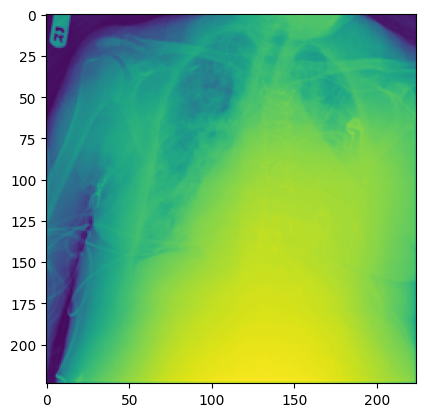

In [ ]:
plt.imshow(image)

In [ ]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms

class DenseNet121(nn.Module):
    """Model modified.

    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.

    """
    def __init__(self, out_size):
        super(DenseNet121, self).__init__()
        self.densenet121 = torchvision.models.densenet121(pretrained=True)
        num_ftrs = self.densenet121.classifier.in_features
        self.densenet121.classifier = nn.Sequential(
            nn.Linear(num_ftrs, out_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.densenet121(x)
        return x

model=DenseNet121(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 102MB/s]


In [ ]:

train_dir = os.path.join("/content/drive/MyDrive/colab_data/Train")
test_dir = os.path.join("/content/drive/MyDrive/colab_data/Test")


In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# NUM_WORKERS = os.cpu_count()
NUM_WORKERS=0

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Set the batch size
BATCH_SIZE = 28

import torch
from torchvision.transforms import v2
import torchvision.transforms as transforms


# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=transform,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x792d69c45a20>,
 ['Cardiomegaly', 'Consolidation', 'Effusion'])

In [ ]:
num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of trainable parameters: {num_trainable_params}")

Number of trainable parameters: 6956931


In [ ]:
import torch
from torchsummary import summary

import torch

# Move the model to GPU
model = model.to("cuda")



In [ ]:

"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn

import os
import zipfile

from pathlib import Path

import requests

# Walk through an image classification directory and find out how many files (images)
# are in each subdirectory.
import os

def walk_through_dir(dir_path):

    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):

    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):

    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):

    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):


    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:

    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path


In [ ]:

import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    print("step")
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in tqdm(enumerate(dataloader)):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

    print("Started")
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        checkpoint_filename = '/content/drive/MyDrive/DL-Project/weights/'+str(epoch)+'.pt'
        torch.save(model.state_dict(), checkpoint_filename)
    # Return the filled results at the end of the epochs
    return results

In [ ]:



device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.0001, # Base LR from Table 3 for ViT-* ImageNet-1k
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.01) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k


loss_fn = torch.nn.CrossEntropyLoss()


set_seeds()

results = train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=100,
                       device=device)
checkpoint_filename = '/content/drive/MyDrive/DL-Project/weights/'+str("final")+'.pt'
torch.save(model.state_dict(), checkpoint_filename)


Started


  0%|          | 0/100 [00:00<?, ?it/s]

step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 1.0485 | train_acc: 0.4512 | test_loss: 1.0127 | test_acc: 0.4589
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 0.9731 | train_acc: 0.5396 | test_loss: 0.9107 | test_acc: 0.6115
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 0.9382 | train_acc: 0.5726 | test_loss: 0.8937 | test_acc: 0.6088
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 4 | train_loss: 0.9170 | train_acc: 0.5970 | test_loss: 0.8690 | test_acc: 0.5931
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 5 | train_loss: 0.9098 | train_acc: 0.6029 | test_loss: 0.8791 | test_acc: 0.6629
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 6 | train_loss: 0.9028 | train_acc: 0.6115 | test_loss: 0.9081 | test_acc: 0.5936
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 7 | train_loss: 0.8997 | train_acc: 0.6124 | test_loss: 0.8717 | test_acc: 0.6569
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 8 | train_loss: 0.9023 | train_acc: 0.6089 | test_loss: 0.8946 | test_acc: 0.6272
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 9 | train_loss: 0.8970 | train_acc: 0.6202 | test_loss: 0.9176 | test_acc: 0.6293
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 10 | train_loss: 0.9014 | train_acc: 0.6145 | test_loss: 0.8839 | test_acc: 0.6115
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 11 | train_loss: 0.8898 | train_acc: 0.6326 | test_loss: 0.9002 | test_acc: 0.6120
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 12 | train_loss: 0.9038 | train_acc: 0.6122 | test_loss: 0.8435 | test_acc: 0.6959
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 13 | train_loss: 0.8827 | train_acc: 0.6361 | test_loss: 0.8854 | test_acc: 0.5844
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 14 | train_loss: 0.8856 | train_acc: 0.6344 | test_loss: 0.8628 | test_acc: 0.6802
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 15 | train_loss: 0.8926 | train_acc: 0.6238 | test_loss: 0.8856 | test_acc: 0.5812
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 16 | train_loss: 0.8846 | train_acc: 0.6355 | test_loss: 0.8418 | test_acc: 0.6829
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 17 | train_loss: 0.8794 | train_acc: 0.6435 | test_loss: 0.8998 | test_acc: 0.6061
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 18 | train_loss: 0.8784 | train_acc: 0.6339 | test_loss: 0.8479 | test_acc: 0.6688
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 19 | train_loss: 0.8857 | train_acc: 0.6269 | test_loss: 0.8898 | test_acc: 0.5898
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 20 | train_loss: 0.8779 | train_acc: 0.6412 | test_loss: 0.8507 | test_acc: 0.7100
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 21 | train_loss: 0.8808 | train_acc: 0.6353 | test_loss: 0.8272 | test_acc: 0.7348
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 22 | train_loss: 0.8836 | train_acc: 0.6331 | test_loss: 0.8897 | test_acc: 0.6450
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 23 | train_loss: 0.8861 | train_acc: 0.6334 | test_loss: 0.8684 | test_acc: 0.6412
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 24 | train_loss: 0.8702 | train_acc: 0.6516 | test_loss: 0.8424 | test_acc: 0.6742
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 25 | train_loss: 0.8833 | train_acc: 0.6334 | test_loss: 0.9081 | test_acc: 0.5839
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 26 | train_loss: 0.8808 | train_acc: 0.6277 | test_loss: 0.8792 | test_acc: 0.6596
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 27 | train_loss: 0.8832 | train_acc: 0.6360 | test_loss: 0.8488 | test_acc: 0.7170
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 28 | train_loss: 0.8798 | train_acc: 0.6262 | test_loss: 0.8614 | test_acc: 0.6710
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 29 | train_loss: 0.8676 | train_acc: 0.6560 | test_loss: 0.8759 | test_acc: 0.5931
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 30 | train_loss: 0.8752 | train_acc: 0.6342 | test_loss: 0.9068 | test_acc: 0.6082
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 31 | train_loss: 0.8699 | train_acc: 0.6535 | test_loss: 0.8967 | test_acc: 0.5817
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 32 | train_loss: 0.8716 | train_acc: 0.6393 | test_loss: 0.8839 | test_acc: 0.5871
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 33 | train_loss: 0.8859 | train_acc: 0.6285 | test_loss: 0.8499 | test_acc: 0.6840
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 34 | train_loss: 0.8671 | train_acc: 0.6516 | test_loss: 0.8593 | test_acc: 0.6683
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 35 | train_loss: 0.8629 | train_acc: 0.6561 | test_loss: 0.8806 | test_acc: 0.6115
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 36 | train_loss: 0.8707 | train_acc: 0.6460 | test_loss: 0.8587 | test_acc: 0.6234
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 37 | train_loss: 0.8665 | train_acc: 0.6556 | test_loss: 0.8206 | test_acc: 0.7105
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 38 | train_loss: 0.8618 | train_acc: 0.6512 | test_loss: 0.8534 | test_acc: 0.6564
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 39 | train_loss: 0.8688 | train_acc: 0.6493 | test_loss: 0.8665 | test_acc: 0.6023
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 40 | train_loss: 0.8599 | train_acc: 0.6594 | test_loss: 0.8785 | test_acc: 0.6109
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 41 | train_loss: 0.8604 | train_acc: 0.6587 | test_loss: 0.8475 | test_acc: 0.6596
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 42 | train_loss: 0.8681 | train_acc: 0.6530 | test_loss: 0.8635 | test_acc: 0.6023
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 43 | train_loss: 0.8564 | train_acc: 0.6662 | test_loss: 0.8290 | test_acc: 0.6769
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 44 | train_loss: 0.8666 | train_acc: 0.6579 | test_loss: 0.8328 | test_acc: 0.7013
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 45 | train_loss: 0.8578 | train_acc: 0.6694 | test_loss: 0.8525 | test_acc: 0.6531
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 46 | train_loss: 0.8616 | train_acc: 0.6666 | test_loss: 0.8527 | test_acc: 0.6797
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 47 | train_loss: 0.8618 | train_acc: 0.6589 | test_loss: 0.8835 | test_acc: 0.6288
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 48 | train_loss: 0.8670 | train_acc: 0.6532 | test_loss: 0.8596 | test_acc: 0.6564
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 49 | train_loss: 0.8604 | train_acc: 0.6661 | test_loss: 0.8394 | test_acc: 0.7013
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 50 | train_loss: 0.8648 | train_acc: 0.6545 | test_loss: 0.8571 | test_acc: 0.6623
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 51 | train_loss: 0.8567 | train_acc: 0.6643 | test_loss: 0.8476 | test_acc: 0.6623
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 52 | train_loss: 0.8514 | train_acc: 0.6657 | test_loss: 0.8649 | test_acc: 0.6115
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 53 | train_loss: 0.8504 | train_acc: 0.6608 | test_loss: 0.8391 | test_acc: 0.6867
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 54 | train_loss: 0.8476 | train_acc: 0.6706 | test_loss: 0.8291 | test_acc: 0.7045
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 55 | train_loss: 0.8550 | train_acc: 0.6649 | test_loss: 0.8929 | test_acc: 0.6169
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 56 | train_loss: 0.8587 | train_acc: 0.6629 | test_loss: 0.8541 | test_acc: 0.6380
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 57 | train_loss: 0.8602 | train_acc: 0.6589 | test_loss: 0.8442 | test_acc: 0.7018
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 58 | train_loss: 0.8564 | train_acc: 0.6657 | test_loss: 0.8249 | test_acc: 0.7013
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 59 | train_loss: 0.8460 | train_acc: 0.6827 | test_loss: 0.8193 | test_acc: 0.6932
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 60 | train_loss: 0.8499 | train_acc: 0.6754 | test_loss: 0.8478 | test_acc: 0.6710
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 61 | train_loss: 0.8437 | train_acc: 0.6840 | test_loss: 0.8410 | test_acc: 0.6829
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 62 | train_loss: 0.8609 | train_acc: 0.6597 | test_loss: 0.8339 | test_acc: 0.7165
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 63 | train_loss: 0.8499 | train_acc: 0.6704 | test_loss: 0.8283 | test_acc: 0.7078
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 64 | train_loss: 0.8583 | train_acc: 0.6662 | test_loss: 0.8699 | test_acc: 0.6477
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 65 | train_loss: 0.8551 | train_acc: 0.6621 | test_loss: 0.8322 | test_acc: 0.6899
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 66 | train_loss: 0.8428 | train_acc: 0.6730 | test_loss: 0.8418 | test_acc: 0.6872
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 67 | train_loss: 0.8441 | train_acc: 0.6829 | test_loss: 0.8246 | test_acc: 0.7040
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 68 | train_loss: 0.8431 | train_acc: 0.6779 | test_loss: 0.8558 | test_acc: 0.6656
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 69 | train_loss: 0.8453 | train_acc: 0.6782 | test_loss: 0.8347 | test_acc: 0.6618
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 70 | train_loss: 0.8464 | train_acc: 0.6787 | test_loss: 0.8365 | test_acc: 0.6807
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 71 | train_loss: 0.8477 | train_acc: 0.6757 | test_loss: 0.8382 | test_acc: 0.6742
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 72 | train_loss: 0.8511 | train_acc: 0.6712 | test_loss: 0.8638 | test_acc: 0.6564
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 73 | train_loss: 0.8516 | train_acc: 0.6649 | test_loss: 0.8194 | test_acc: 0.7219
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 74 | train_loss: 0.8436 | train_acc: 0.6800 | test_loss: 0.8753 | test_acc: 0.6261
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 75 | train_loss: 0.8418 | train_acc: 0.6779 | test_loss: 0.8380 | test_acc: 0.6802
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 76 | train_loss: 0.8418 | train_acc: 0.6795 | test_loss: 0.8535 | test_acc: 0.6807
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 77 | train_loss: 0.8527 | train_acc: 0.6712 | test_loss: 0.8487 | test_acc: 0.6531
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 78 | train_loss: 0.8384 | train_acc: 0.6886 | test_loss: 0.8333 | test_acc: 0.6710
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 79 | train_loss: 0.8400 | train_acc: 0.6800 | test_loss: 0.8345 | test_acc: 0.6775
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 80 | train_loss: 0.8482 | train_acc: 0.6767 | test_loss: 0.8335 | test_acc: 0.7192
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 81 | train_loss: 0.8430 | train_acc: 0.6844 | test_loss: 0.8844 | test_acc: 0.6445
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 82 | train_loss: 0.8503 | train_acc: 0.6770 | test_loss: 0.8451 | test_acc: 0.6645
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 83 | train_loss: 0.8484 | train_acc: 0.6671 | test_loss: 0.8852 | test_acc: 0.6418
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 84 | train_loss: 0.8419 | train_acc: 0.6879 | test_loss: 0.8247 | test_acc: 0.7008
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 85 | train_loss: 0.8442 | train_acc: 0.6779 | test_loss: 0.8827 | test_acc: 0.5898
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 86 | train_loss: 0.8477 | train_acc: 0.6823 | test_loss: 0.8369 | test_acc: 0.6769
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 87 | train_loss: 0.8367 | train_acc: 0.6887 | test_loss: 0.8774 | test_acc: 0.6353
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 88 | train_loss: 0.8450 | train_acc: 0.6689 | test_loss: 0.8446 | test_acc: 0.6975
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 89 | train_loss: 0.8442 | train_acc: 0.6763 | test_loss: 0.8221 | test_acc: 0.6834
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 90 | train_loss: 0.8391 | train_acc: 0.6927 | test_loss: 0.8639 | test_acc: 0.6266
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 91 | train_loss: 0.8391 | train_acc: 0.6803 | test_loss: 0.8879 | test_acc: 0.6466
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 92 | train_loss: 0.8374 | train_acc: 0.6896 | test_loss: 0.8488 | test_acc: 0.6234
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 93 | train_loss: 0.8439 | train_acc: 0.6886 | test_loss: 0.8364 | test_acc: 0.6802
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 94 | train_loss: 0.8388 | train_acc: 0.6882 | test_loss: 0.8420 | test_acc: 0.6807
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 95 | train_loss: 0.8351 | train_acc: 0.6910 | test_loss: 0.8147 | test_acc: 0.6889
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 96 | train_loss: 0.8331 | train_acc: 0.6994 | test_loss: 0.8024 | test_acc: 0.7430
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 97 | train_loss: 0.8315 | train_acc: 0.6957 | test_loss: 0.8382 | test_acc: 0.6688
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 98 | train_loss: 0.8397 | train_acc: 0.6933 | test_loss: 0.8412 | test_acc: 0.7462
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 99 | train_loss: 0.8351 | train_acc: 0.6928 | test_loss: 0.8624 | test_acc: 0.6715
step


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 100 | train_loss: 0.8448 | train_acc: 0.6793 | test_loss: 0.8398 | test_acc: 0.6618


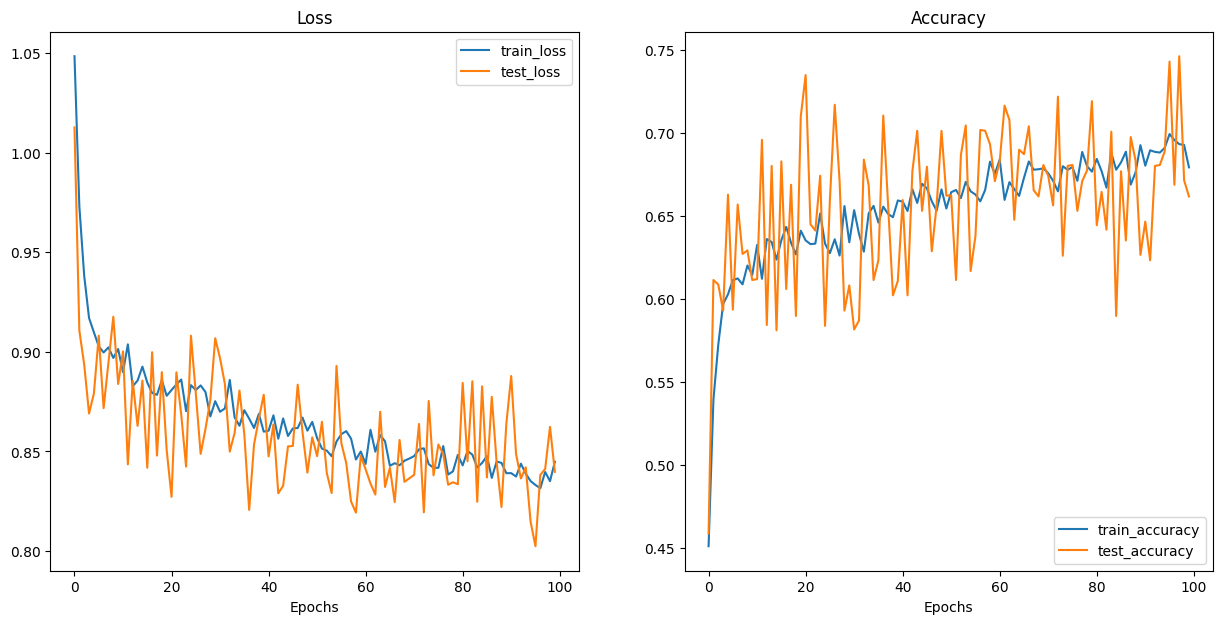

In [ ]:

plot_loss_curves(results)

### Inference

In [ ]:
import torch
torch.__version__

'2.1.0+cu118'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

In [ ]:
import os
class_names=["Cardiomegaly","Consolidation","Effusion"]
from torchvision import datasets, transforms

In [ ]:


model.load_state_dict(torch.load('/content/drive/MyDrive/DL-Project/weights/final.pt'), strict=False)


<All keys matched successfully>

In [ ]:
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image
import cv2
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path).convert('RGB')



    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                # transforms.Normalize(
                #     mean=[0.556, 0.447, 0.335], std=[0.231, 0.242, 0.238]
                # ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    return class_names[target_image_pred_label]


In [ ]:
import requests


paths=[ "/content/drive/MyDrive/colab_data/Test/Effusion/","/content/drive/MyDrive/colab_data/Test/Consolidation/" ,"/content/drive/MyDrive/colab_data/Test/Cardiomegaly/"]
#paths=[ "/content/drive/MyDrive/DL_Project/colab_data/Test/Consolidation/"]
Effusion=0
Consolidation = 0
Cardiomegaly= 0
preds=[]
gts=[]
for p in paths:
  for ims in os.listdir(p):
      pat=os.path.join(p,ims)



      # Predict on custom image
      classname = pred_and_plot_image(model=model,
                          image_path=pat,
                          class_names=class_names)
      g=p.split("/")[-2]
      # gts.append(g)

      if g=='Effusion':
          gts.append(1)
      elif g=='Consolidation':
          gts.append(2)
      elif g=='Cardiomegaly':
          gts.append(3)


      if classname=='Effusion':
          a=1
      elif classname=='Consolidation':
          a=2
      elif classname=='Cardiomegaly':
          a=3
      preds.append(a)








In [ ]:
print(preds)

[3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 3, 1, 1, 1, 3, 2, 1, 1, 2, 3, 2, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 3, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 3, 3, 1, 3, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 2, 3, 3, 3, 3, 3, 3]


In [ ]:
print(gts)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [ ]:



from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Replace 'ground_truth' and 'predictions' with your actual ground truth and prediction values
ground_truth = gts
predictions = preds


# Calculate accuracy
accuracy = accuracy_score(ground_truth, predictions)
print(f'Accuracy: {accuracy:.2f}')

# Calculate precision, recall, and F1 score for each class
precision = precision_score(ground_truth, predictions, average='macro')
recall = recall_score(ground_truth, predictions, average='macro')
f1 = f1_score(ground_truth, predictions, average='macro')

print(f'\nPrecision: {precision:.2f}')
print(f'\nRecall: {recall:.2f}')
print(f'\nF1 Score: {f1:.2f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(ground_truth, predictions)
print('\nConfusion Matrix:')
print(conf_matrix)

# Generate a classification report
class_report = classification_report(ground_truth, predictions)
print('\nClassification Report:')
print(class_report)


Accuracy: 0.73

Precision: 0.73

Recall: 0.73

F1 Score: 0.73

Confusion Matrix:
[[32 16  6]
 [ 8 35  5]
 [ 1  5 43]]

Classification Report:
              precision    recall  f1-score   support

           1       0.78      0.59      0.67        54
           2       0.62      0.73      0.67        48
           3       0.80      0.88      0.83        49

    accuracy                           0.73       151
   macro avg       0.73      0.73      0.73       151
weighted avg       0.74      0.73      0.73       151

